In [3192]:
import os
import re
import json
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression   
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline   
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3193]:
df = pd.read_csv('mobile_data.csv')

In [3194]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5910 non-null   object 
 1   brand             5910 non-null   object 
 2   2G                5910 non-null   bool   
 3   3G                5910 non-null   bool   
 4   4G                5910 non-null   bool   
 5   5G                5910 non-null   bool   
 6   Announced         5839 non-null   object 
 7   Status            5910 non-null   object 
 8   Weight            5598 non-null   float64
 9   Length            5903 non-null   object 
 10  Width             5795 non-null   object 
 11  Diameter          5792 non-null   float64
 12  SIM               3984 non-null   object 
 13  Display Type      5910 non-null   object 
 14  Display Size      5530 non-null   float64
 15  PPI               5507 non-null   float64
 16  Body Ratio        5281 non-null   float64


,name,brand,2G,3G,4G,5G,Announced,Status,Weight,Length,...,Bluetooth,GPU,LoudSpeaker,3.5mm jack,Chipset,Network,Internal,Card slot,RAM,Storage
0,1,alcatel,True,True,True,False,July 2018,Available,134.0,137.6,...,"4.2, A2DP, LE",PowerVR GE8100,True,True,Mediatek MT6739 (28 nm),GSM / HSPA / LTE,"8GB 1GB RAM, 16GB 1GB RAM",microSDHC (dedicated slot),1GB,"16GB, 8GB"
1,3,alcatel,True,True,True,False,February 2018,Available,145.0,147.1,...,"4.2, A2DP, LE",PowerVR GE8100,True,True,Mediatek MT6739 (28 nm),GSM / HSPA / LTE,16GB 2GB RAM,microSDXC,2GB,16GB
2,5,alcatel,True,True,True,False,February 2018,Available,144.0,152.3,...,"4.2, A2DP, LE",Mali-T860MP2,True,True,Mediatek MT6750 (28 nm),GSM / HSPA / LTE,"16GB 2GB RAM, 32GB 3GB RAM",microSDXC,"2GB, 3GB","16GB, 32GB"
3,7,alcatel,True,True,True,False,August 2018,Available,175.0,162.1,...,"4.0, A2DP, LE",Mali-G71 MP2,True,True,Mediatek MT6763T Helio P23 (16 nm),GSM / HSPA / LTE,32GB 2GB RAM,microSDXC (dedicated slot),2GB,32GB
4,2000,alcatel,True,False,False,False,November 2013,discontinued,89.0,112,...,"3.0, A2DP, EDR",NaN,True,True,NaN,GSM,NaN,microSDHC (dedicated slot),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5905,F101,ZTE,True,True,False,False,2009,discontinued,90.0,105,...,"2.1, A2DP",NaN,True,False,NaN,GSM / UMTS,NaN,microSDHC (dedicated slot),NaN,NaN
5906,F100,ZTE,True,True,False,False,2009,discontinued,90.0,105,...,"2.1, A2DP",NaN,True,False,NaN,GSM / UMTS,NaN,microSDHC (dedicated slot),NaN,NaN
5907,Coral200 Sollar,ZTE,True,False,False,False,May 2007,discontinued,85.0,106,...,No,NaN,False,False,NaN,GSM,4MB,No,NaN,4MB
5908,Blade V20,ZTE,True,True,True,False,NaN,discontinued,NaN,-,...,"4.2, A2DP, LE",NaN,True,True,NaN,GSM / HSPA / LTE,64GB 4GB RAM,microSDXC,4GB,64GB


In [3195]:
missing_percentage = df.isnull().mean() * 100  
pd.DataFrame(missing_percentage)

,0
name,0.000000
brand,0.000000
2G,0.000000
3G,0.000000
4G,0.000000
...,...
Network,0.000000
Internal,9.340102
Card slot,0.000000
RAM,32.690355


<Axes: >

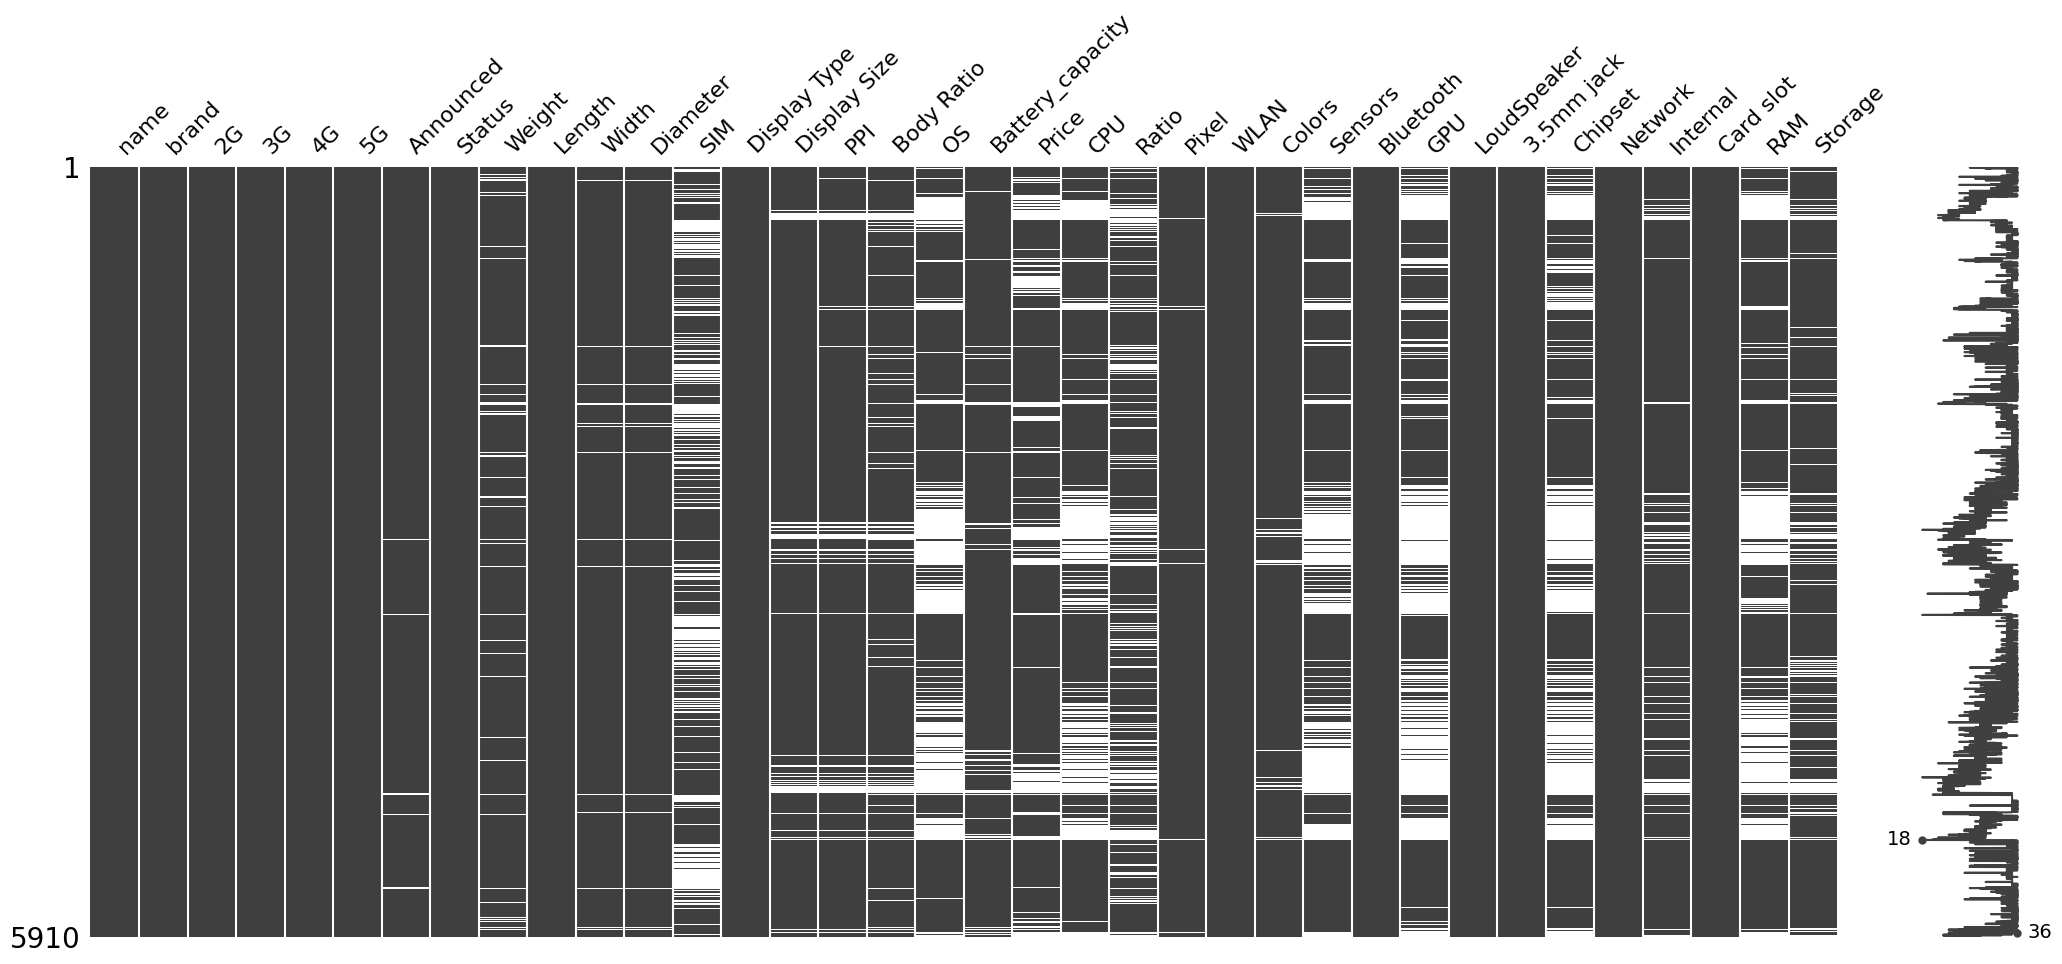

In [3196]:
msno.matrix(df)

In [3197]:
null_values = df['Price'].isnull().sum() 

In [3198]:
null_values # These records don't have price, we can use them for testing phase later; maybe?!

1195

In [3199]:
df = df.dropna(subset=['Price'])   # Removed rows with Null value as their price 
df.shape

(4715, 36)

In [3200]:
pd.set_option('display.max_rows', None)        # Show all rows  
pd.set_option('display.max_columns', None)     # Show all columns  

In [3201]:
pd.set_option('display.max_rows', 10)        # Default Settings  
pd.set_option('display.max_columns', 20)      

In [3202]:
def extract_price_in_eur(price_str):  
    usd_pattern = re.compile(r'\$\s*(\d+(\.\d+)?)') 
    gbp_pattern = re.compile(r'£\s*(\d+(\.\d+)?)') 
    inr_pattern = re.compile(r'₹\s*(\d+(\.\d+)?)') 
    
    try:
        # Handle cases with '€' in it initial state
        if '€' in price_str:   
            euro_price = 0
            parts = price_str.split('€')[1]
            parts1 = parts.split(' ')[0]
            price_float = float(parts1.replace(',', '')) 
            return price_float 
        
        # Handle cases with 'About' in it 
        elif 'About' in price_str:  
            if 'BTC' in price_str:
                parts3 = price_str.split(' ')[2]
                parts4 = parts3.split('/')[0]
                return float(parts4) * 94044.08

            else:
                return float(price_str.split(' ')[1])

        # Handle cases with converting $ to €
        elif usd_pattern.search(price_str):  
            return float(usd_pattern.search(price_str).group(1)) * 0.97

        # Handle cases with converting £ to €
        elif gbp_pattern.search(price_str):  
            return float(gbp_pattern.search(price_str).group(1)) * 1.18

         # Handle cases with converting ₹ to €
        elif inr_pattern.search(price_str):  
            inr_price = 0
            parts5 = price_str.split('₹')[1]
            parts6 = parts5.split(' ')[0]
            price_float = float(parts6.replace(',', '')) 
            return price_float * 0.011

    except Exception as e:    
        print(f"An error occurred: {e}")  
        return -1  # Return -1 if no price found or invalid format

In [3203]:
df['Price'] = df['Price'].apply(extract_price_in_eur)  

C:\Users\user\AppData\Local\Temp\ipykernel_40252\3150977457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price'] = df['Price'].apply(extract_price_in_eur)


In [3204]:
df = df[df['Price'] < 2500]

In [3205]:
def convert_to_mb(value):
    if pd.isna(value):
        return None
    
    if isinstance(value, str):
        values_mb = []
        for item in value.split(', '):
            match = re.match(r'(\d+)([A-Z]{2})', item)
            if match:
                num, unit = match.groups()
                num = float(num)
                if unit == 'GB':
                    values_mb.append(num * 1024)
                elif unit == 'MB':
                    values_mb.append(num)
                elif unit == 'KB':
                    values_mb.append(num / 1024)
        return ', '.join(map(str, map(int, values_mb))) if values_mb else None
    elif isinstance(value, (int, float)):
        return str(int(value))
    else:
        return None

In [3206]:
df['RAM'] = df['RAM'].apply(convert_to_mb)
df['Storage'] = df['Storage'].apply(convert_to_mb)

In [3207]:
def extract_year(date_str):
    if re.match(r'^\d{4}$', str(date_str)):
        return int(date_str)
    match = re.search(r'\b\d{4}\b', str(date_str))
    if match:
        return int(match.group())
    return pd.NaT

In [3208]:
df['Announced'] = df['Announced'].apply(extract_year)

In [3209]:
df = df[~df['name'].str.contains('Watch', case=False)]    # Watches should be removed from the dataset

In [3210]:
df = df.drop(columns=['Network', 'Internal', 'Ratio', 'Colors'])

In [3211]:
def compute_pixel_product(pixel_str):  
    # Check if pixel_str is a string  
    if isinstance(pixel_str, str):    
        width, height = map(int, pixel_str.split(' x '))    
        return width * height  
    return None 

df['Pixel'] = df['Pixel'].apply(compute_pixel_product)  

In [3212]:
# Extract numerical part, handling invalid entries by using na=False  
df['Battery_capacity'] = df['Battery_capacity'].str.extract('(\d+)', expand=False)  

# Convert to numeric, forcing errors to NaN  
df['Battery_capacity'] = pd.to_numeric(df['Battery_capacity'], errors='coerce')  

In [3213]:
df['Accelerometer'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'accelerometer' in x.lower() else 0)  
df['Fingerprint'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'fingerprint' in x.lower() else 0)  
df['Proximity'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'proximity' in x.lower() else 0)  
df['Compass'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'compass' in x.lower() else 0)  
df['Face ID'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'face id' in x.lower() else 0)  
df['Gyro'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'gyro' in x.lower() else 0)  
df['Barometer'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'barometer' in x.lower() else 0)  
df['Iris Scanner'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'iris scanner' in x.lower() else 0)  
df['Color Spectrum'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'color spectrum' in x.lower() else 0)  
df['Heart Rate'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'heart rate' in x.lower() else 0)  
df['SPO2 ID'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'spo2' in x.lower() else 0)  
df['Temperature'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'temperature' in x.lower() else 0)  
df['UV'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'uv' in x.lower() else 0)  
df['Ambient Light'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'ambient light' in x.lower() else 0)  
df['Humidity'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'humidity' in x.lower() else 0)  
df['Gesture'] = df['Sensors'].apply(lambda x: 1 if isinstance(x, str) and 'gesture' in x.lower() else 0)  

df = df.drop(columns=['Sensors'])

In [3214]:
df['A2DP'] = df['Bluetooth'].apply(lambda y: 1 if isinstance(y, str) and 'A2DP' in y else 0)  
df['LE'] = df['Bluetooth'].apply(lambda y: 1 if isinstance(y, str) and 'LE' in y else 0)  
df['EDR'] = df['Bluetooth'].apply(lambda y: 1 if isinstance(y, str) and 'EDR' in y else 0)  
df['aptX'] = df['Bluetooth'].apply(lambda y: 1 if isinstance(y, str) and 'aptX' in y else 0)  
df['L2HC'] = df['Bluetooth'].apply(lambda y: 1 if isinstance(y, str) and 'L2HC' in y else 0)  

# Function to extract and convert the Bluetooth version to int  
def convert_bluetooth_to_int(bluetooth_str):   
    bluetooth_str = str(bluetooth_str)  
    try:  
        first_part = bluetooth_str.split(',')[0]  
        return float(first_part)
    except ValueError:  # Handle cases that cannot be converted  
        return 0

df['BT Version'] = df['Bluetooth'].apply(convert_bluetooth_to_int) 

df = df.drop(columns=['Bluetooth'])

In [3215]:
df['IPS'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'IPS' in x else 0)  
df['TFT'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'TFT' in x else 0)  
df['AMOLED'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'AMOLED' in x else 0)  
df['OLED'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'OLED' in x else 0)  
df['Super'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'Super' in x else 0)  
df['LCD'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'LCD' in x else 0)  
df['TN'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'TN' in x else 0)  
df['PLS'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'PLS' in x else 0)  
df['LED-backlit'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'LED-backlit' in x else 0)  
df['LTPO'] = df['Display Type'].apply(lambda x: 1 if isinstance(x, str) and 'LTPO' in x else 0)  

df = df.drop(columns=['Display Type'])

In [3216]:
def CPU_Core(CPU_value):  
    if pd.isna(CPU_value): 
        return 0  
    elif 'Octa' in CPU_value:  
        return 8  
    elif 'Hexa' in CPU_value:  
        return 6  
    elif 'Quad' in CPU_value:  
        return 4  
    elif 'Dual' in CPU_value:  
        return 2  
    
df['CPU Core'] = df['CPU'].map(CPU_Core)  

In [3217]:
def SIM_label_encoding(sim_value):  
    if pd.isna(sim_value):  
        return 0  
    elif 'nano-sim' in sim_value.lower():  
        return 3  
    elif 'micro-sim' in sim_value.lower():  
        return 2  
    elif 'mini-sim' in sim_value.lower():  
        return 1  
    
df['SIM'] = df['SIM'].map(SIM_label_encoding)  

In [3218]:
df['2G'] = df['2G'].astype(int)  
df['3G'] = df['3G'].astype(int)  
df['4G'] = df['4G'].astype(int)  
df['5G'] = df['5G'].astype(int)  

In [3219]:
df['3.5mm jack'] = df['3.5mm jack'].astype(int)  
df['LoudSpeaker'] = df['LoudSpeaker'].astype(int)  

In [3220]:
def Status_label_encoding(status_value):  
    if pd.isna(status_value):  
        return -1  
    elif 'Coming' in status_value:
        return 1  
    elif 'Available' in status_value:
        return 1  
    elif 'discontinued' in status_value:
        return 0  
    else:  
        return -1 
    
df['Status'] = df['Status'].map(Status_label_encoding)  

In [3221]:
def get_max_storage(storage_value):  
    if pd.isna(storage_value):  # Check for None or NaN  
        return None
    # Split the string by commas, convert to integers, and return the maximum value  
    return max(map(int, storage_value.split(',')))  

df['Storage'] = df['Storage'].apply(get_max_storage)  

In [3222]:
def get_max_ram(ram_value):  
    if pd.isna(ram_value):  # Check for None or NaN  
        return None
    # Split the string by commas, convert to integers, and return the maximum value  
    return max(map(int, ram_value.split(',')))  
  
df['RAM'] = df['RAM'].apply(get_max_ram)  

In [3223]:
df['WiFi'] = df['WLAN'].apply(lambda x: 1 if isinstance(x, str) and 'Wi-Fi' in x else 0)  
df['hotspot'] = df['WLAN'].apply(lambda x: 1 if isinstance(x, str) and 'hotspot' in x else 0)  
df['DLNA'] = df['WLAN'].apply(lambda x: 1 if isinstance(x, str) and 'DLNA' in x else 0)

df = df.drop(columns=['WLAN'])

In [3224]:
df['Width'] = pd.to_numeric(df['Width'], errors='coerce')  
df['Length'] = pd.to_numeric(df['Length'], errors='coerce')  

In [3225]:
df[['Speed', 'Unit']] = df['CPU'].str.extract(r'(\d+\.\d+|\d+)\s*(GHz|MHz)', expand=True)  

# Convert to MHz  
df['CPU Speed'] = df.apply(lambda x: float(x['Speed']) * 1000 if x['Unit'] == 'GHz' else float(x['Speed']), axis=1)  

df = df.drop(columns=['Speed', 'Unit'])

In [3226]:
def assign_cpu_core(value):  
    if value < 1:  
        return 0  
    elif 1 <= value < 3:  
        return 2  
    elif 3 <= value < 5:  
        return 4  
    elif 5 <= value < 7:  
        return 6  
    elif value >= 7:     
        return 8   

df['CPU Core'] = df['CPU Core'].apply(assign_cpu_core)  

In [3227]:
df['Cortex'] = df['CPU'].apply(lambda x: 1 if isinstance(x, str) and 'Cortex' in x else 0)  
df['Krait'] = df['CPU'].apply(lambda x: 1 if isinstance(x, str) and 'Krait' in x else 0)  
df['Scorpion'] = df['CPU'].apply(lambda x: 1 if isinstance(x, str) and 'Scorpion' in x else 0)
df['Twister'] = df['CPU'].apply(lambda x: 1 if isinstance(x, str) and 'Twister' in x else 0)  
df['ARM'] = df['CPU'].apply(lambda x: 1 if isinstance(x, str) and 'ARM' in x else 0)  
df['Swift'] = df['CPU'].apply(lambda x: 1 if isinstance(x, str) and 'Swift' in x else 0)  

In [3228]:
# def assign_cpu_model(cpu_value):  
#     if '55' in cpu_value: 
#         return 30 
#     elif '53' in cpu_value: 
#         return 25
#     elif '11' in cpu_value:  
#         return 18
#     elif '9' in cpu_value: 
#         return 16
#     elif '8' in cpu_value: 
#         return 14
#     elif '7' in cpu_value:  
#         return 12 
#     elif '5' in cpu_value: 
#         return 10  
#     elif 'ARM' in cpu_value: 
#         return 5
#     elif 'Krait' in cpu_value:  
#         return 5  
#     elif 'Scorpion' in cpu_value: 
#         return 1
#     else:
#         return 0
    
# df['CPU Name'] = df['CPU'].apply(assign_cpu_model)

In [3229]:
def extract_brand_and_number(gpu_str):  
    # Ensure the input is a string  
    gpu_str = str(gpu_str)  
    # Match to find numbers  
    number_match = re.search(r'(\d+)', gpu_str)  
    # Match to find the brand (first part before any digit)  
    brand_match = re.match(r'([A-Za-z]+)', gpu_str)  
    number = number_match.group(1) if number_match else None  
    brand = brand_match.group(1) if brand_match else None  
    
    if brand and '-' in gpu_str:  
        brand = brand.split('-')[0]  # Just take the part before a dash for brands with '-' in them  

    return brand, number  

# Create new columns for each brand and fill them with the extracted numbers  
for gpu in df['GPU']:  
    brand, number = extract_brand_and_number(gpu)  
    if brand and number:  
        col_name = brand.replace(" ", "_")  # Replace spaces with underscores for column names  
        if col_name not in df.columns:  
            df[col_name] = None  # Create the new column if it doesn't exist  
        df.loc[df['GPU'] == gpu, col_name] = number  # Assign extracted number  

new_columns = df.columns[-14:]  # Get the new columns that were created  
df[new_columns] = df[new_columns].fillna(0) 
df[new_columns] = df[new_columns].astype(int)


In [3230]:
df = pd.get_dummies(df, columns=['brand'], drop_first=False)  
df.loc[:, df.columns.str.startswith('brand_')] = df.loc[:, df.columns.str.startswith('brand_')].astype(int)  

<Figure size 1000x500 with 0 Axes>

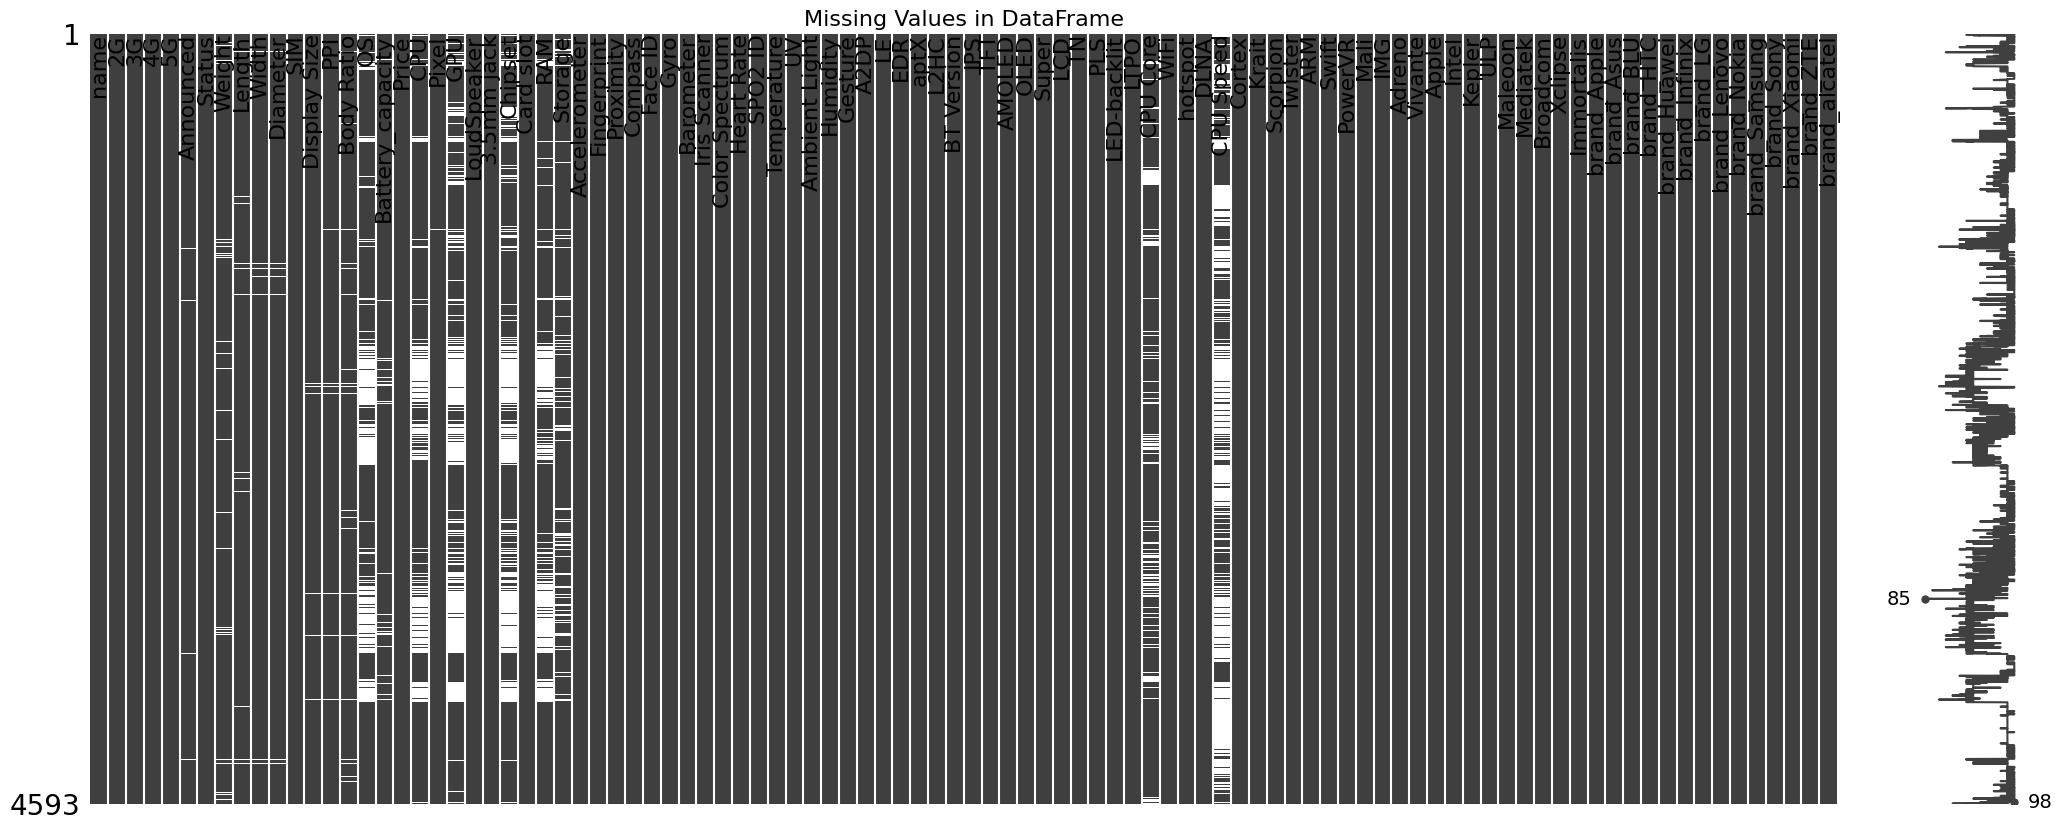

In [3231]:
plt.figure(figsize=(10, 5))
msno.matrix(df)  
plt.title('Missing Values in DataFrame', fontsize=16)  

# Get column positions for annotations  
column_labels = df.columns  
num_columns = len(column_labels)  
x_positions = [i for i in range(num_columns)]  

# Annotate each column with its name vertically  
for x, column in zip(x_positions, column_labels):  
    plt.annotate(column, xy=(x, -0.05), ha='center', va='top', fontsize=16, color='black', rotation=90)  

plt.show()  

In [3232]:
df, test_df = train_test_split(df, test_size=0.15, random_state=42)

### Fill NaN Values

In [3233]:
mean_announced = df.groupby('OS')['Announced'].mean().copy() 

df['Announced'] = df['Announced'].fillna(df['OS'].map(mean_announced.astype(int)))  

df = df.drop(columns=['OS'])

In [3234]:
test_df['Announced'] = test_df['Announced'].fillna(test_df['OS'].map(mean_announced.astype(int)))

test_df = test_df.drop(columns=['OS'])

In [3235]:
mean_battery_capacity = df.groupby('Display Size')['Battery_capacity'].mean().reset_index()  
mean_battery_capacity = mean_battery_capacity.sort_values(by=['Display Size'], ascending=True)
mean_battery_capacity['Battery_capacity'] = mean_battery_capacity['Battery_capacity'].fillna(method='bfill')

# Convert to Series while keeping only the 'Display Size' as index  
battery_series = mean_battery_capacity.set_index('Display Size')['Battery_capacity']  

# Fill NaN values in 'Battery_capacity' with the mean based on 'Display Size'  
df['Battery_capacity'] = df['Battery_capacity'].fillna(df['Display Size'].map(battery_series.astype(int)))  

In [3236]:
test_df['Battery_capacity'] = test_df['Battery_capacity'].fillna(test_df['Display Size'].map(battery_series.astype(int)))

In [3237]:
# average_price = df.groupby('brand')['Price'].mean().reset_index()  
# average_price.sort_values(by=['Price'])

In [3238]:
# def brand_label_encoding(brand_value):  
#     if 'Apple' in brand_value: 
#         return 13  
#     elif 'Asus' in brand_value: 
#         return 12
#     elif 'Infinix' in brand_value:  
#         return 11
#     elif 'Huawei' in brand_value: 
#         return 10
#     elif 'Xiaomi' in brand_value: 
#         return 9
#     elif 'ZTE' in brand_value:  
#         return 8  
#     elif 'HTC' in brand_value: 
#         return 7  
#     elif 'Sony' in brand_value: 
#         return 6
#     elif 'Lenovo' in brand_value:  
#         return 5  
#     elif 'Samsung' in brand_value: 
#         return 4  
#     elif 'LG' in brand_value: 
#         return 3
#     elif 'Nokia' in brand_value:  
#         return 2
#     elif 'alcatel' in brand_value: 
#         return 1 
#     elif 'BLU' in brand_value: 
#         return 0
#     else:  
#         return -1 
    
# df['brand'] = df['brand'].apply(brand_label_encoding)  

In [3239]:
train_df = df.dropna(subset=['Length', 'Display Size'])  

# Prepare the data for regression  
X = train_df[['Length']]  
y = train_df['Display Size']  

# Fit the model  
model_Length_DisplaySize = LinearRegression()  
model_Length_DisplaySize.fit(X, y)  

# Predict missing values  
missing_values = df[df['Display Size'].isnull()]['Length']  

# Reshape missing values for prediction  
predicted_values = model_Length_DisplaySize.predict(missing_values.values.reshape(-1, 1))  

# Fill the missing storage values  
df.loc[df['Display Size'].isnull(), 'Display Size'] = predicted_values

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3240]:
missing_values_test = test_df[test_df['Display Size'].isnull()]['Length']

predicted_values_test = model_Length_DisplaySize.predict(missing_values_test.values.reshape(-1, 1))

test_df.loc[test_df['Display Size'].isnull(), 'Display Size'] = predicted_values_test

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3241]:
train_df = df.dropna(subset=['Length', 'Display Size'])  

# Prepare the data for regression  
X = train_df[['Display Size']]  
y = train_df['Length']  

# Fit the model  
model_DisplaySize_Length = LinearRegression()  
model_DisplaySize_Length.fit(X, y)  

# Predict missing values  
missing_values = df[df['Length'].isnull()]['Display Size']  

# Reshape missing values for prediction  
predicted_values = model_DisplaySize_Length.predict(missing_values.values.reshape(-1, 1))  

# Fill the missing storage values  
df.loc[df['Length'].isnull(), 'Length'] = predicted_values

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3242]:
missing_values_test = test_df[test_df['Length'].isnull()]['Display Size']

predicted_values_test = model_DisplaySize_Length.predict(missing_values_test.values.reshape(-1, 1))

test_df.loc[test_df['Length'].isnull(), 'Length'] = predicted_values_test

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3243]:
train_df = df.dropna(subset=['Width', 'Display Size'])  

# Prepare the data for regression  
X = train_df[['Display Size']]  
y = train_df['Width']  

# Fit the model  
model_DisplaySize_Width = LinearRegression()  
model_DisplaySize_Width.fit(X, y)  

# Predict missing values  
missing_values = df[df['Width'].isnull()]['Display Size']  

# Reshape missing values for prediction  
predicted_values = model_DisplaySize_Width.predict(missing_values.values.reshape(-1, 1))  

# Fill the missing storage values  
df.loc[df['Width'].isnull(), 'Width'] = predicted_values

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3244]:
missing_values_test = test_df[test_df['Width'].isnull()]['Display Size']

predicted_values_test = model_DisplaySize_Width.predict(missing_values_test.values.reshape(-1, 1))

test_df.loc[test_df['Width'].isnull(), 'Width'] = predicted_values_test

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3245]:
train_df = df.dropna(subset=['Weight', 'Width'])  

# Prepare the data for regression  
X = train_df[['Width']]  
y = train_df['Weight']  

# Fit the model  
model_Width_Weight = LinearRegression()  
model_Width_Weight.fit(X, y)  

# Predict missing values  
missing_values = df[df['Weight'].isnull()]['Width']  

# Reshape missing values for prediction  
predicted_values = model_Width_Weight.predict(missing_values.values.reshape(-1, 1))  

# Fill the missing storage values  
df.loc[df['Weight'].isnull(), 'Weight'] = predicted_values

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3246]:
missing_values_test = test_df[test_df['Weight'].isnull()]['Width']

predicted_values_test = model_Width_Weight.predict(missing_values_test.values.reshape(-1, 1))

test_df.loc[test_df['Weight'].isnull(), 'Weight'] = predicted_values_test

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3247]:
train_df = df.dropna(subset=['Body Ratio', 'Display Size'])  

# Prepare the data for regression  
X = train_df[['Display Size']]  
y = train_df['Body Ratio']  

# Fit the model  
model_DisplaySize_BodyRatio = LinearRegression()  
model_DisplaySize_BodyRatio.fit(X, y)  

# Predict missing values  
missing_values = df[df['Body Ratio'].isnull()]['Display Size']  

# Reshape missing values for prediction  
predicted_values = model_DisplaySize_BodyRatio.predict(missing_values.values.reshape(-1, 1))  

# Fill the missing storage values  
df.loc[df['Body Ratio'].isnull(), 'Body Ratio'] = predicted_values

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3248]:
missing_values_test = test_df[test_df['Body Ratio'].isnull()]['Display Size']

predicted_values_test = model_DisplaySize_BodyRatio.predict(missing_values_test.values.reshape(-1, 1))

test_df.loc[test_df['Body Ratio'].isnull(), 'Body Ratio'] = predicted_values_test

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3249]:
train_df = df.dropna(subset=['Diameter', 'Body Ratio'])  

# Prepare the data for regression  
X = train_df[['Body Ratio']]  
y = train_df['Diameter']  

# Fit the model  
model_BodyRatio_Diameter = LinearRegression()  
model_BodyRatio_Diameter.fit(X, y)  

# Predict missing values  
missing_values = df[df['Diameter'].isnull()]['Body Ratio']  

# Reshape missing values for prediction  
predicted_values = model_BodyRatio_Diameter.predict(missing_values.values.reshape(-1, 1))  

# Fill the missing storage values  
df.loc[df['Diameter'].isnull(), 'Diameter'] = predicted_values

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3250]:
missing_values_test = test_df[test_df['Diameter'].isnull()]['Body Ratio']

predicted_values_test = model_BodyRatio_Diameter.predict(missing_values_test.values.reshape(-1, 1))

test_df.loc[test_df['Diameter'].isnull(), 'Diameter'] = predicted_values_test

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3251]:
train_df = df.dropna(subset=['Body Ratio', 'Pixel'])  

# Prepare the data for regression  
X = train_df[['Body Ratio']]  
y = train_df['Pixel']  

# Fit the model  
model_BodyRatio_Pixel = LinearRegression()  
model_BodyRatio_Pixel.fit(X, y)  

# Predict missing values  
missing_values = df[df['Pixel'].isnull()]['Body Ratio']  

# Reshape missing values for prediction  
predicted_values = model_BodyRatio_Pixel.predict(missing_values.values.reshape(-1, 1))  

# Fill the missing storage values  
df.loc[df['Pixel'].isnull(), 'Pixel'] = predicted_values

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3252]:
missing_values_test = test_df[test_df['Pixel'].isnull()]['Body Ratio']

predicted_values_test = model_BodyRatio_Pixel.predict(missing_values_test.values.reshape(-1, 1))

test_df.loc[test_df['Pixel'].isnull(), 'Pixel'] = predicted_values_test

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3253]:
train_df = df.dropna(subset=['PPI', 'Pixel'])  

# Prepare the data for regression  
X = train_df[['Pixel']]  
y = train_df['PPI']  

# Fit the model  
model_Pixel_PPI = LinearRegression()  
model_Pixel_PPI.fit(X, y)  

# Predict missing values  
missing_values = df[df['PPI'].isnull()]['Pixel']  

# Reshape missing values for prediction  
predicted_values = model_Pixel_PPI.predict(missing_values.values.reshape(-1, 1))  

# Fill the missing storage values  
df.loc[df['PPI'].isnull(), 'PPI'] = predicted_values

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3254]:
missing_values_test = test_df[test_df['PPI'].isnull()]['Pixel']

predicted_values_test = model_Pixel_PPI.predict(missing_values_test.values.reshape(-1, 1))

test_df.loc[test_df['PPI'].isnull(), 'PPI'] = predicted_values_test

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3255]:
train_df = df.dropna(subset=['Storage', 'Pixel', '5G'])  

# Prepare the data for regression  
X = train_df[['Pixel', '5G']]  
y = train_df['Storage']  

# Fit the model  
model_Pixel_5G_Storage = LinearRegression()  
model_Pixel_5G_Storage.fit(X, y)  

# Predict missing values  
missing_values = df[df['Storage'].isnull()][['Pixel', '5G']]  

# No need to reshape; use missing_values directly  
predicted_values = model_Pixel_5G_Storage.predict(missing_values)  

# Fill the missing storage values  
df.loc[df['Storage'].isnull(), 'Storage'] = predicted_values

In [3256]:
missing_values_test = test_df[test_df['Storage'].isnull()][['Pixel', '5G']]  

predicted_values_test = model_Pixel_5G_Storage.predict(missing_values_test)

test_df.loc[test_df['Storage'].isnull(), 'Storage'] = predicted_values_test

In [3257]:
def Storage_RAM_mapper(value):
    if value < 3:
        return 2
    if 3 <= value < 6:
        return 4
    if 6 <= value < 12:
        return 8
    elif 12 <= value < 24:
        return 16
    elif 16 <= value < 48:
        return 32
    elif 48 <= value < 96:
        return 64
    elif 96 <= value < 192:
        return 128
    elif 192 <= value < 384:
        return 256
    elif 384 <= value < 768:
        return 512
    elif 768 <= value < 1536:
        return 1024
    elif 1536 <= value < 3072:
        return 2048
    elif 3072 <= value < 6120:
        return 4096
    elif 6120 <= value < 12240:
        return 8192
    elif 12240 <= value < 24576:
        return 16384
    elif 24576 <= value < 49152:
        return 32768
    elif 49152 <= value < 98304:
        return 65536
    elif 98304 <= value < 196608:
        return 131072
    elif 196608 <= value < 393216:
        return 262144
    elif 393216 <= value < 786432:
        return 524288
    elif 786432 <= value:
        return 1048576
    else:
        return None

In [3258]:
df['Storage'] = df['Storage'].apply(Storage_RAM_mapper)

In [3259]:
test_df['Storage'] = test_df['Storage'].apply(Storage_RAM_mapper)

In [3260]:
train_df = df.dropna(subset=['RAM', 'Storage'])  

# Prepare the data for regression  
X = train_df[['Storage']]  
y = train_df['RAM']  

# Fit the model  
model_Storage_RAM = LinearRegression()  
model_Storage_RAM.fit(X, y)  

# Predict missing values  
missing_values = df[df['RAM'].isnull()]['Storage']  

# Reshape missing values for prediction  
predicted_values = model_Storage_RAM.predict(missing_values.values.reshape(-1, 1))  

# Fill the missing storage values  
df.loc[df['RAM'].isnull(), 'RAM'] = predicted_values

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3261]:
missing_values_test = test_df[test_df['RAM'].isnull()]['Storage']  

predicted_values_test = model_Storage_RAM.predict(missing_values_test.values.reshape(-1, 1))

test_df.loc[test_df['RAM'].isnull(), 'RAM'] = predicted_values_test

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [3262]:
df['RAM'] = df['RAM'].apply(Storage_RAM_mapper)

In [3263]:
test_df['RAM'] = test_df['RAM'].apply(Storage_RAM_mapper)

In [3264]:
train_df = df.dropna(subset=['Body Ratio', 'Pixel', 'CPU Speed'])  

# Prepare the data for regression  
X = train_df[['Pixel', 'Body Ratio']]  
y = train_df['CPU Speed']  

# Fit the model  
model_Pixel_BodyRatio_CPUSpeed = LinearRegression()  
model_Pixel_BodyRatio_CPUSpeed.fit(X, y)  

# Predict missing values  
missing_values = df[df['CPU Speed'].isnull()][['Pixel', 'Body Ratio']]  

# No need to reshape; use missing_values directly  
predicted_values = model_Pixel_BodyRatio_CPUSpeed.predict(missing_values)  

# Fill the missing storage values  
df.loc[df['CPU Speed'].isnull(), 'CPU Speed'] = predicted_values

In [3265]:
missing_values_test = test_df[test_df['CPU Speed'].isnull()][['Pixel', 'Body Ratio']]  

predicted_values_test = model_Pixel_BodyRatio_CPUSpeed.predict(missing_values_test)

test_df.loc[test_df['CPU Speed'].isnull(), 'CPU Speed'] = predicted_values_test

In [3266]:
train_df = df.dropna(subset=['CPU Core', 'Body Ratio', 'Announced'])  

# Prepare the data for regression  
X = train_df[['Body Ratio', 'Announced']]  
y = train_df['CPU Core']  

# Fit the model  
model_BodyRatio_Announced_Core = LinearRegression()  
model_BodyRatio_Announced_Core.fit(X, y)  

# Predict missing values  
missing_values = df[df['CPU Core'].isnull()][['Body Ratio', 'Announced']]  

# No need to reshape; use missing_values directly  
predicted_values = model_BodyRatio_Announced_Core.predict(missing_values)  

# Fill the missing storage values  
df.loc[df['CPU Core'].isnull(), 'CPU Core'] = predicted_values

In [3267]:
missing_values_test = test_df[test_df['CPU Core'].isnull()][['Body Ratio', 'Announced']]   

predicted_values_test = model_BodyRatio_Announced_Core.predict(missing_values_test)

test_df.loc[test_df['CPU Core'].isnull(), 'CPU Core'] = predicted_values_test

### Plotting

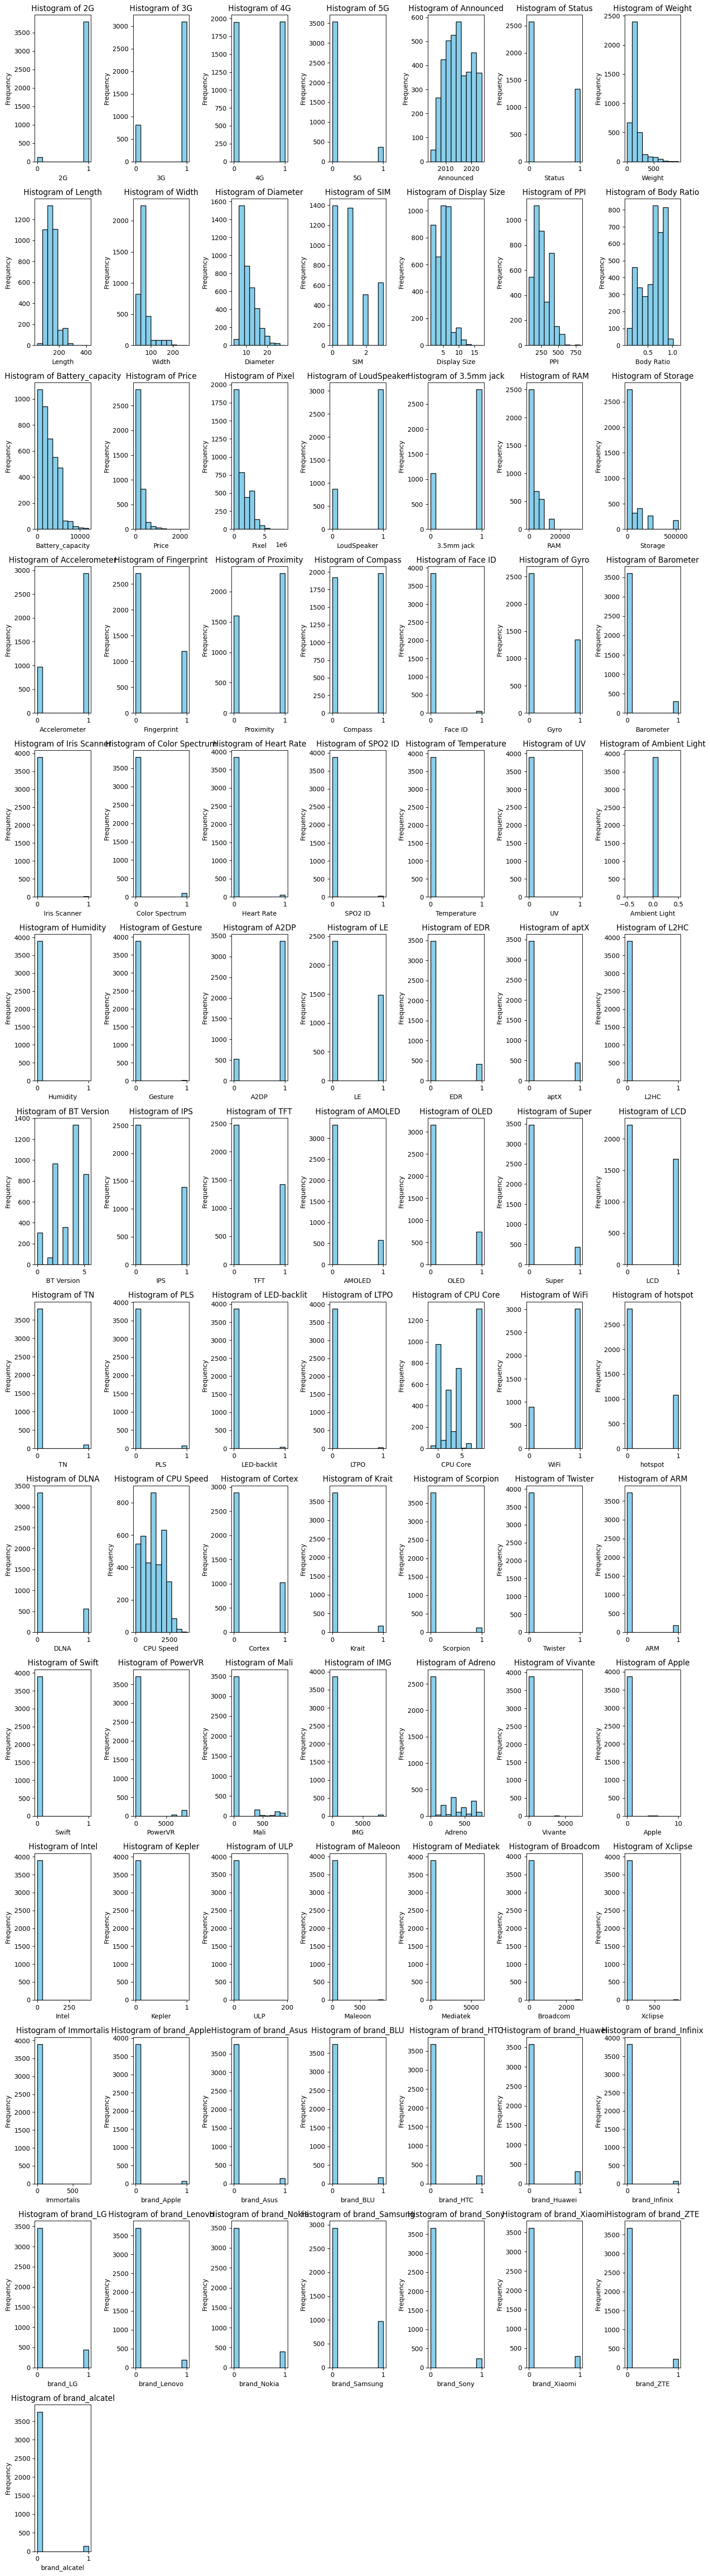

In [3268]:
numeric_cols = df.select_dtypes(include='number').columns  

n_cols = 7 
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))  
axes = axes.flatten()

for i, col in enumerate(numeric_cols):  
    axes[i].hist(df[col], bins=10, color='skyblue', edgecolor='black')  
    axes[i].set_title(f'Histogram of {col}')  
    axes[i].set_xlabel(col)  
    axes[i].set_ylabel('Frequency')  

for j in range(i + 1, len(axes)):  
    fig.delaxes(axes[j])  

plt.tight_layout()  
plt.show()  

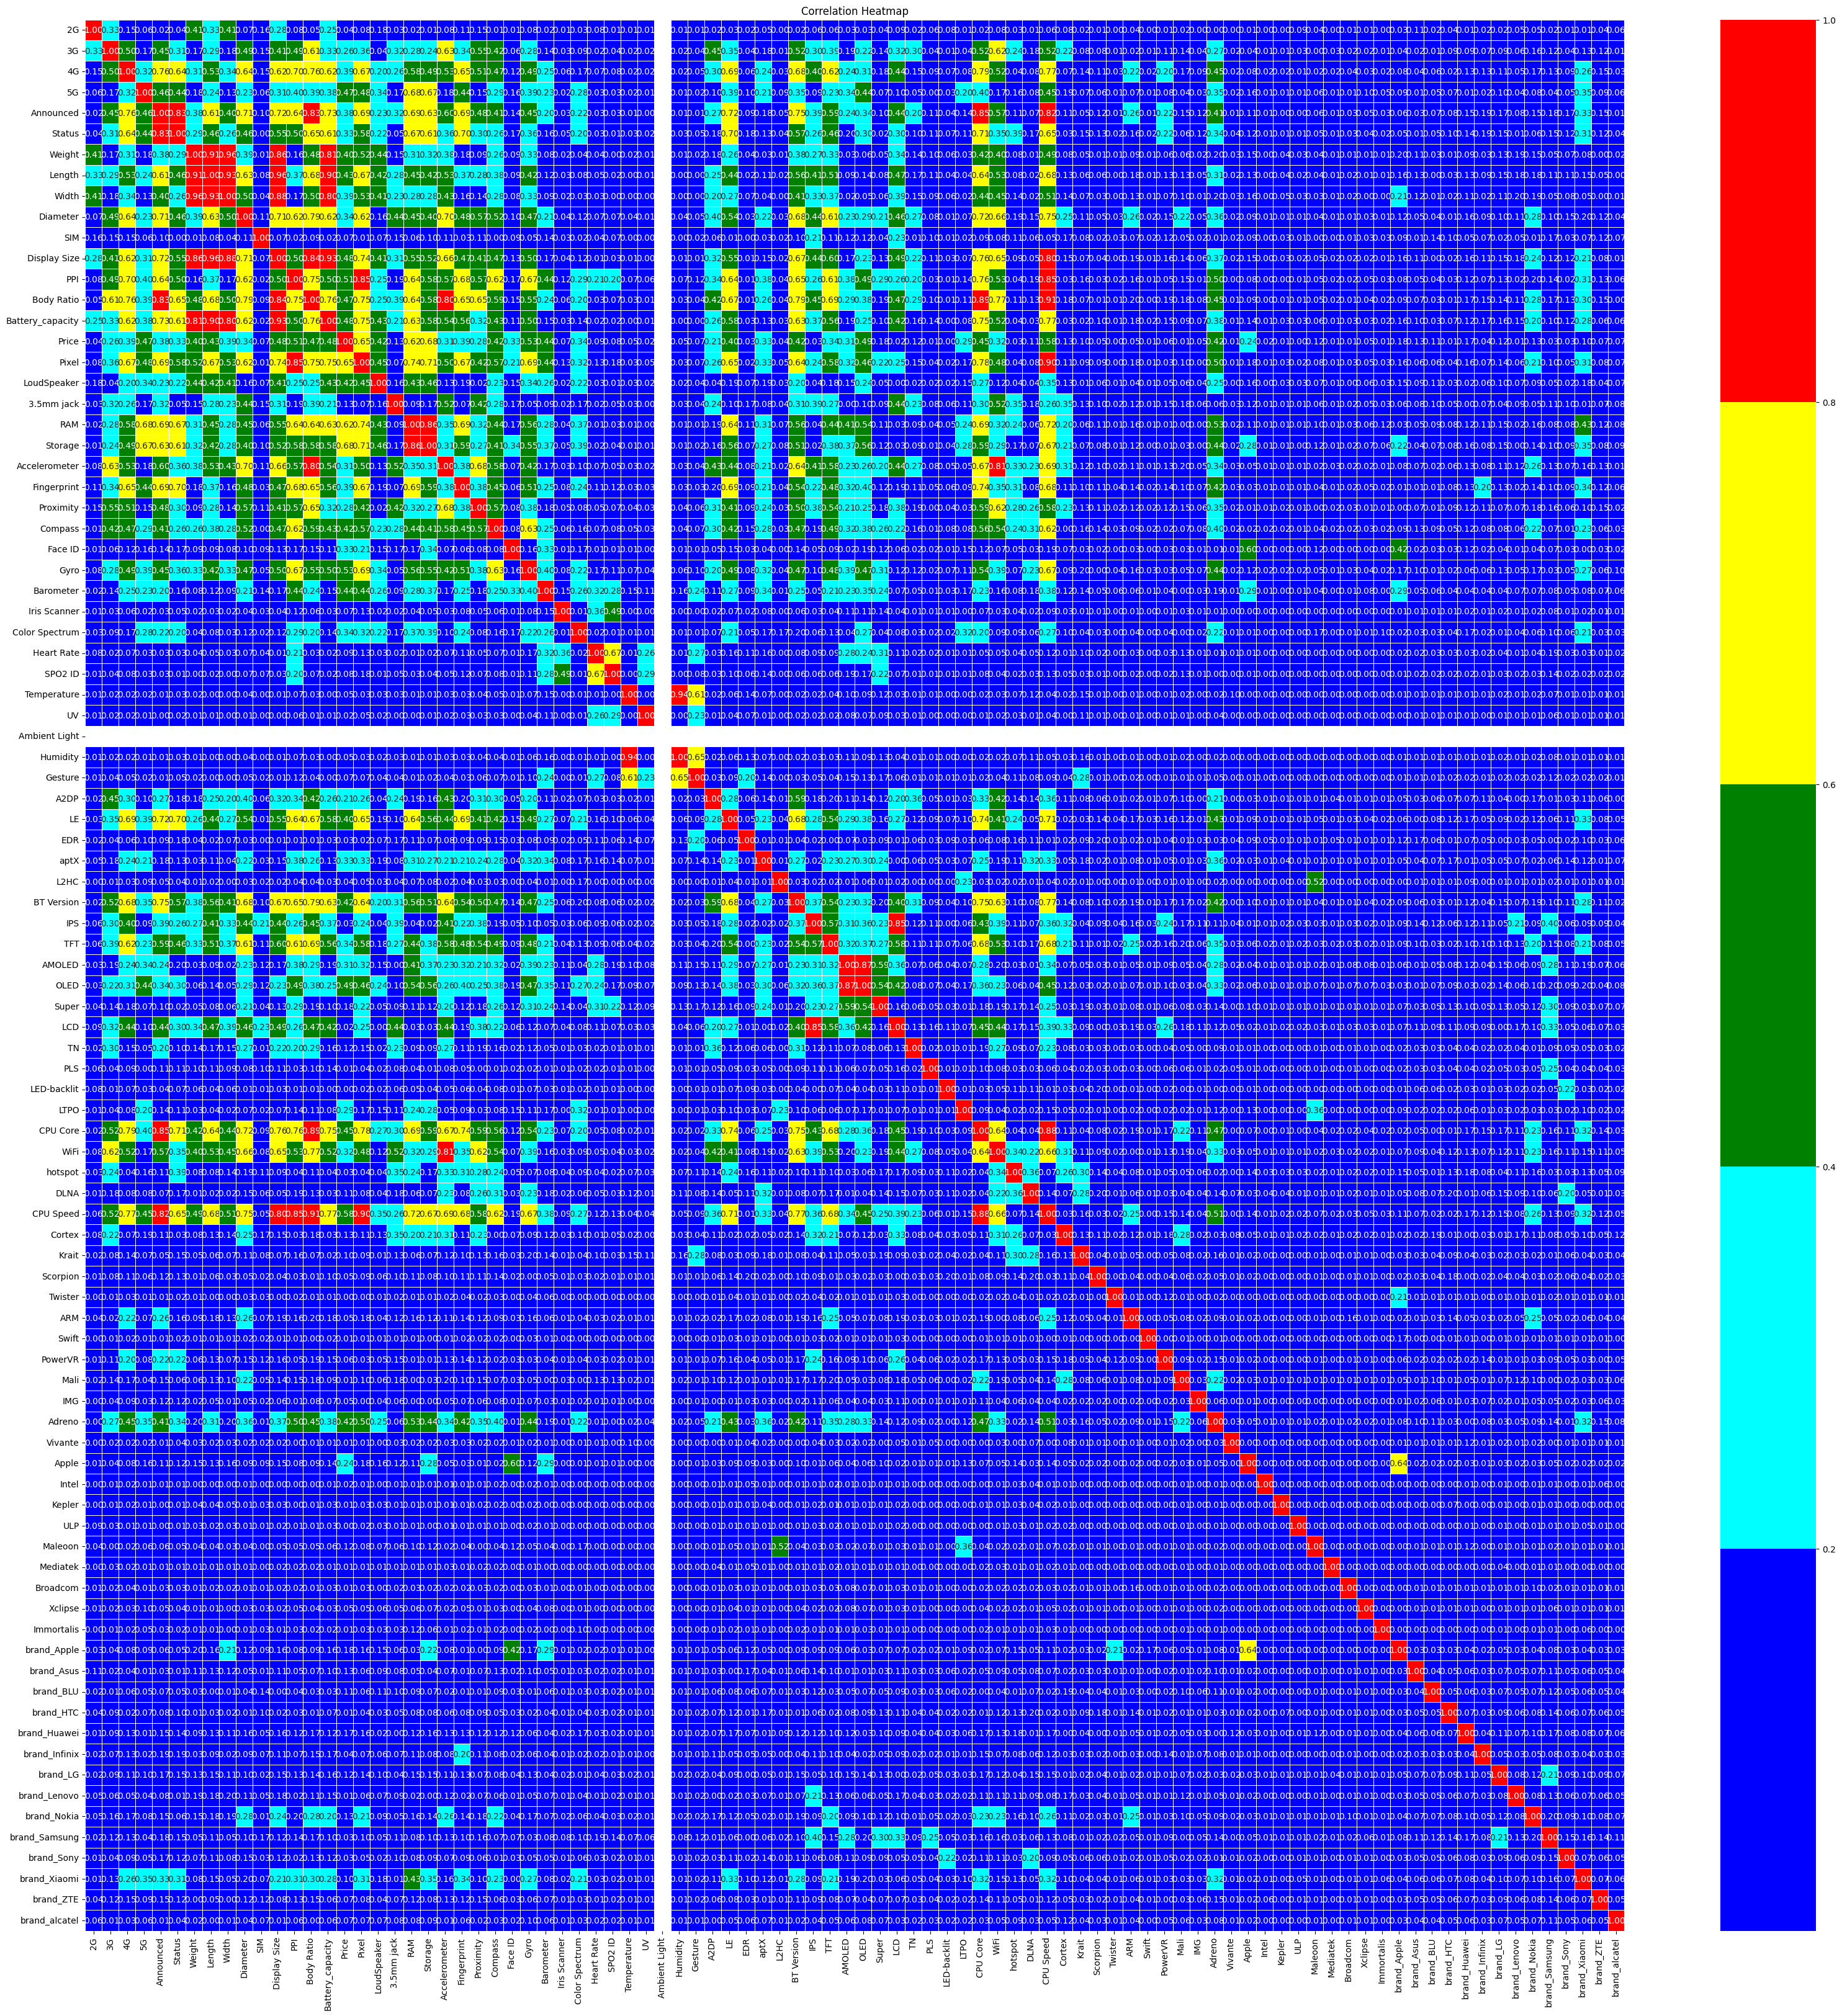

In [3269]:
numeric_df = df.select_dtypes(include=[np.number])  

# Calculate the absolute correlation  
corr_df = numeric_df.corr().abs()  

# Plot the heatmap to check the correlation between the variables  
plt.figure(figsize=(40, 40))  
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap=['blue', 'cyan', 'green', 'yellow', 'red'], linewidths=0.5)  
plt.title('Correlation Heatmap')  
plt.show()  

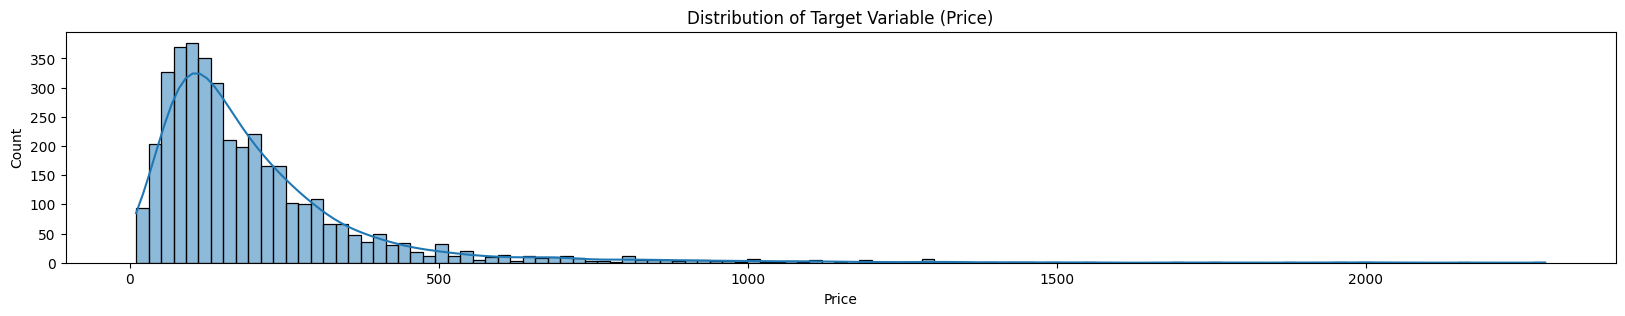

In [3270]:
plt.figure(figsize=(20, 3))
sns.histplot(df['Price'], kde=True)
plt.title('Distribution of Target Variable (Price)')
plt.show()

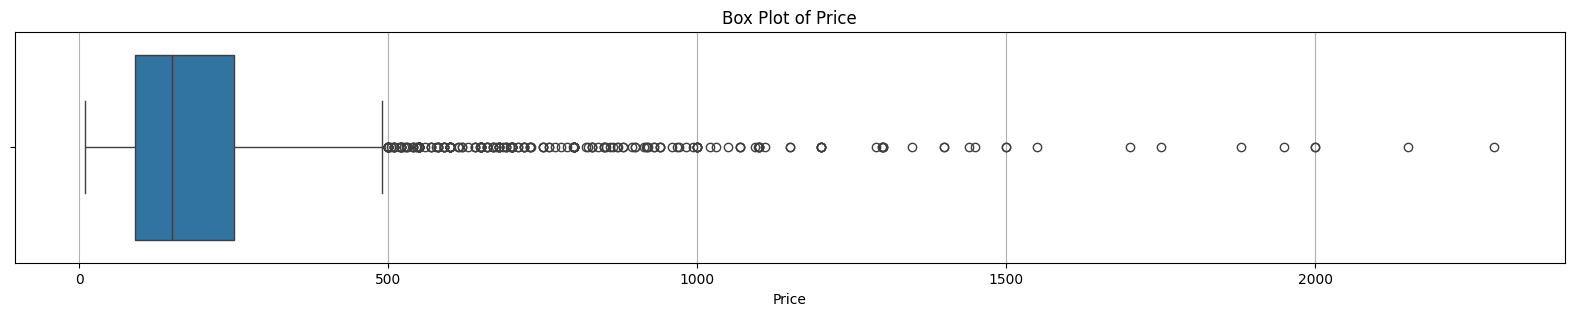

In [3271]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=df['Price']) 
plt.title('Box Plot of Price')  
plt.xlabel('Price')  
plt.grid(axis='x')
plt.show()  

<Figure size 1000x500 with 0 Axes>

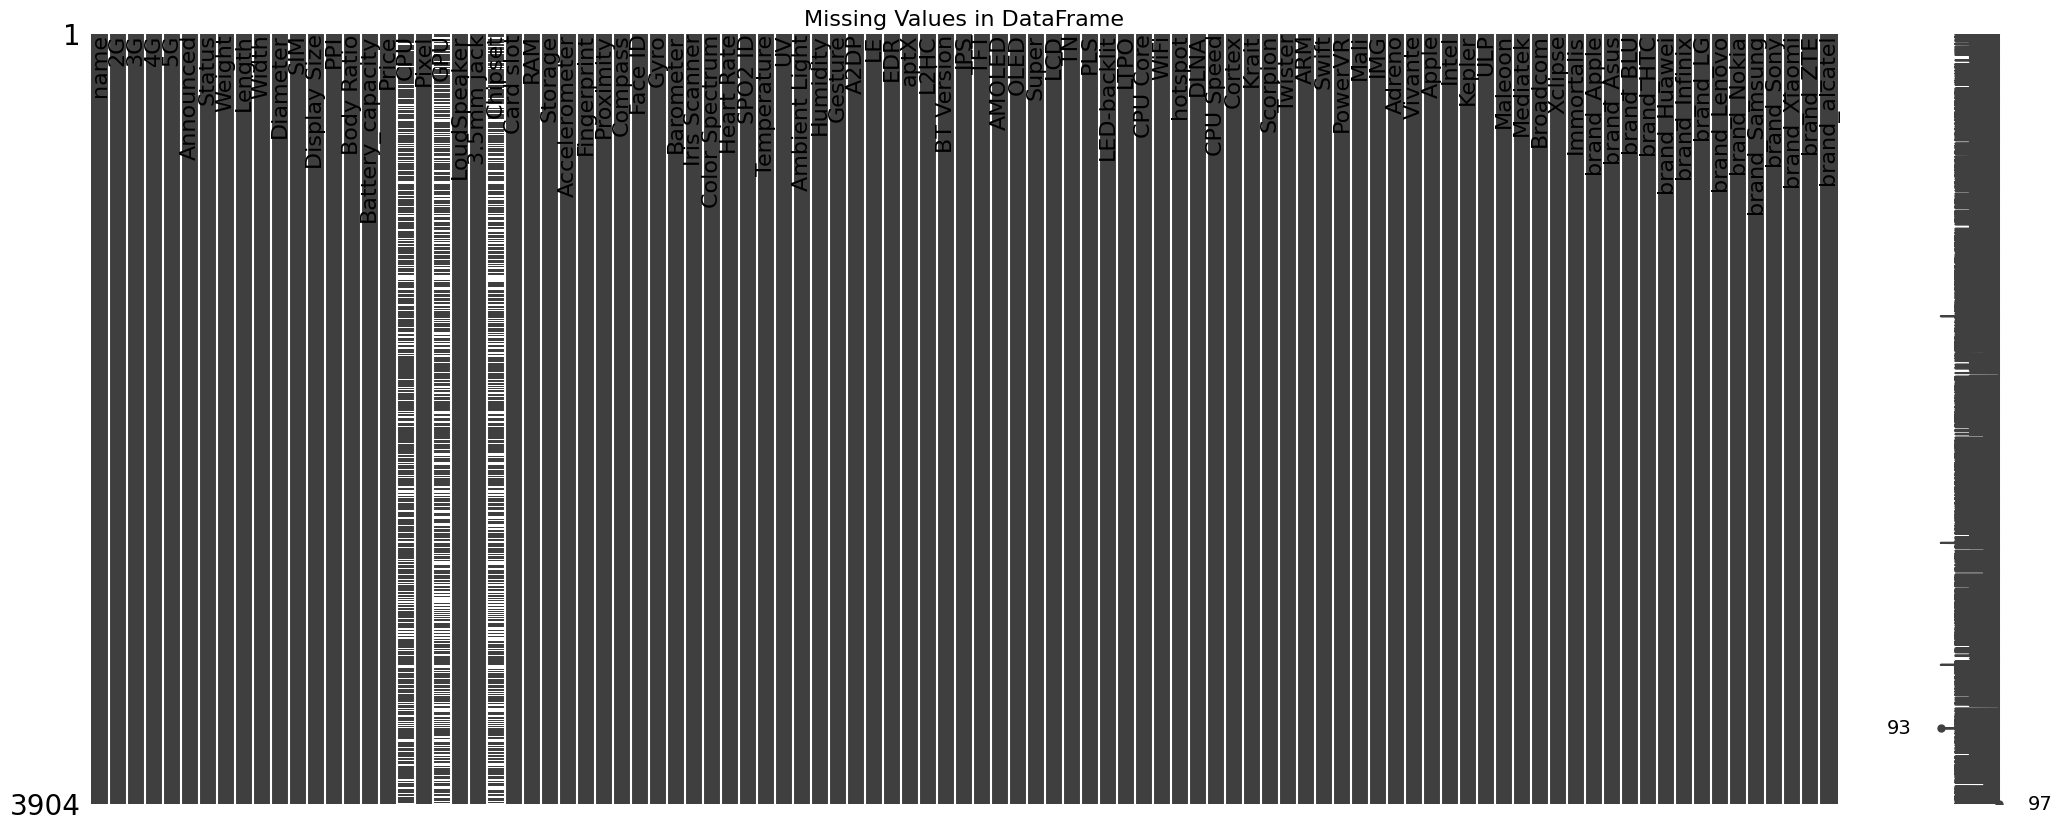

In [3272]:
plt.figure(figsize=(10, 5))
msno.matrix(df)  
plt.title('Missing Values in DataFrame', fontsize=16)  

# Get column positions for annotations  
column_labels = df.columns  
num_columns = len(column_labels)  
x_positions = [i for i in range(num_columns)]  

# Annotate each column with its name vertically  
for x, column in zip(x_positions, column_labels):  
    plt.annotate(column, xy=(x, -0.05), ha='center', va='top', fontsize=16, color='black', rotation=90)  

plt.show()  

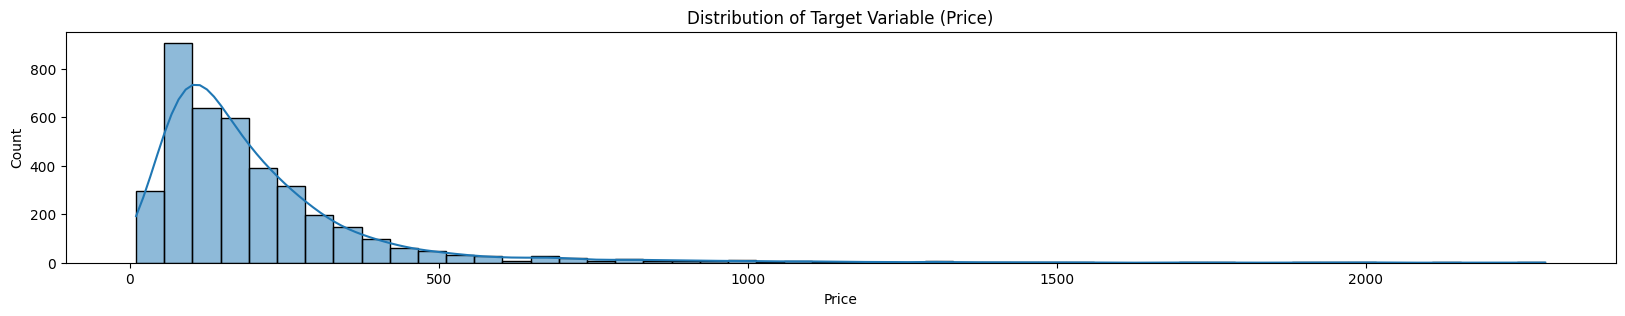

In [3273]:
plt.figure(figsize=(20, 3))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title('Distribution of Target Variable (Price)')
plt.show()

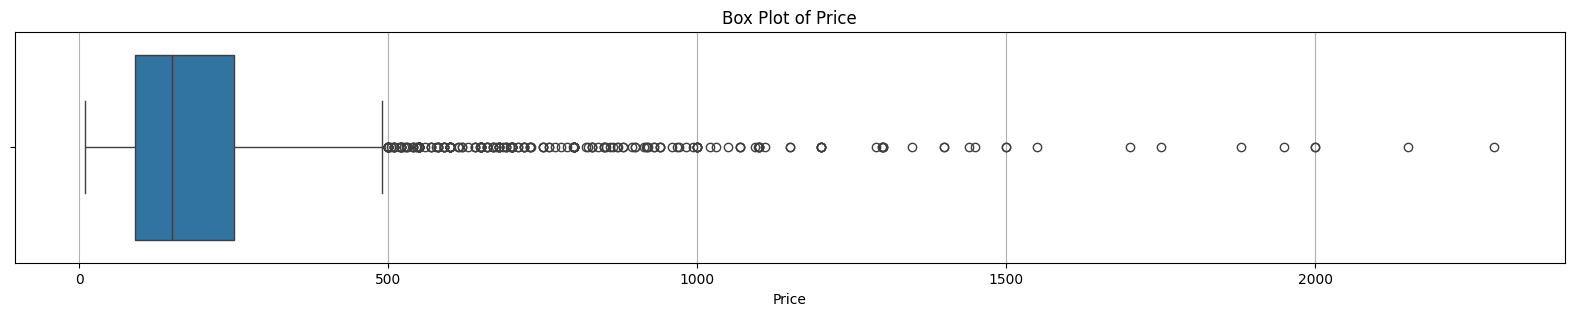

In [3274]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=df['Price']) 
plt.title('Box Plot of Price')  
plt.xlabel('Price')  
plt.grid(axis='x')
plt.show()  

In [3275]:
df

,name,2G,3G,4G,5G,Announced,Status,Weight,Length,Width,...,brand_Huawei,brand_Infinix,brand_LG,brand_Lenovo,brand_Nokia,brand_Samsung,brand_Sony,brand_Xiaomi,brand_ZTE,brand_alcatel
3449,Galaxy Tab S9 FE+,1,1,1,1,2023.0,1,627.0,285.4,185.4,...,0,0,0,0,0,1,0,0,0,0
5021,W205,1,0,0,0,2009.0,0,96.0,92.0,47.0,...,0,0,0,0,0,0,1,0,0,0
5597,nubia Red Magic 6s Pro,1,1,1,1,2021.0,1,215.0,169.9,77.2,...,0,0,0,0,0,0,0,0,1,0
2096,K3,1,0,1,0,2014.0,0,128.0,141.0,70.5,...,0,0,0,1,0,0,0,0,0,0
1107,Desire 22 Pro,1,1,1,1,2022.0,1,205.5,166.3,76.9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5652,nubia Red Magic 3,1,1,1,0,2019.0,1,215.0,171.7,78.5,...,0,0,0,0,0,0,0,0,1,0
748,F91,1,1,1,1,2022.0,1,209.0,168.7,76.8,...,0,0,0,0,0,0,0,0,0,0
3977,Comment 2 R390C,1,0,0,0,2012.0,0,95.0,110.0,61.0,...,0,0,0,0,0,1,0,0,0,0
4896,Xperia C3,1,1,1,0,2014.0,0,149.7,156.2,78.7,...,0,0,0,0,0,0,1,0,0,0


In [3276]:
df = df.drop(columns = ['Ambient Light'])

In [3277]:
test_df = test_df.drop(columns = ['Ambient Light'])

# ***Model Training Proccess***

In [3278]:
X_train = df.select_dtypes(include='number').drop('Price', axis=1)
y_train = df['Price']
X_test = test_df.select_dtypes(include='number').drop('Price', axis=1)
y_test = test_df['Price']

X_test = X_test[X_train.columns]

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test) 

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', Ridge())
])

param_grid = {
    'ridge__alpha': [50.0],
    'poly__degree': [3]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=KFold(n_splits=10, shuffle=True, random_state=42),
                           n_jobs=4)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r_squared = r2_score(y_test, y_test_pred)

print("Test Metrics:")
print(f"Mean Absolute Error: {mae_test}")
print(f"Mean Squared Error: {mse_test}")
print(f"Root Mean Squared Error: {rmse_test}")
print(f"R-squared: {r_squared:.4f}")


Test Metrics:
Mean Absolute Error: 57.347023715459336
Mean Squared Error: 13306.747031133293
Root Mean Squared Error: 115.35487432758657
R-squared: 0.7611


Test Metrics:

Mean Absolute Error: 57.347023715459336

Mean Squared Error: 13306.747031133293

Root Mean Squared Error: 115.35487432758657

R-squared: 0.7611

#### Dropping columns with coorelation less than the specified threshold

In [3279]:
df = df.select_dtypes(include='number')

correlation_matrix = df.corr()  
correlation_with_price = correlation_matrix['Price']  

threshold = 0.3

features_to_drop = correlation_with_price[correlation_with_price.abs() < threshold].index.tolist()  

if 'Price' in features_to_drop:  
    features_to_drop.remove('Price')  

print("Features to drop based on correlation with 'Price':", features_to_drop)  

df = df.drop(columns=features_to_drop)  

Features to drop based on correlation with 'Price': ['2G', '3G', 'SIM', '3.5mm jack', 'Proximity', 'Iris Scanner', 'Heart Rate', 'SPO2 ID', 'Temperature', 'UV', 'Humidity', 'Gesture', 'A2DP', 'EDR', 'L2HC', 'IPS', 'Super', 'LCD', 'TN', 'PLS', 'LED-backlit', 'LTPO', 'hotspot', 'DLNA', 'Cortex', 'Krait', 'Scorpion', 'Twister', 'ARM', 'Swift', 'PowerVR', 'Mali', 'IMG', 'Vivante', 'Apple', 'Intel', 'Kepler', 'ULP', 'Maleoon', 'Mediatek', 'Broadcom', 'Xclipse', 'Immortalis', 'brand_Apple', 'brand_Asus', 'brand_BLU', 'brand_HTC', 'brand_Huawei', 'brand_Infinix', 'brand_LG', 'brand_Lenovo', 'brand_Nokia', 'brand_Samsung', 'brand_Sony', 'brand_Xiaomi', 'brand_ZTE', 'brand_alcatel']


#### Lasso Regression

In [3280]:
X_train = df.select_dtypes(include='number').drop('Price', axis=1)   
y_train = df['Price']  

X_test = test_df.select_dtypes(include='number').drop('Price', axis=1)   
y_test = test_df['Price']  

X_test = X_test[X_train.columns]  

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

pipeline = Pipeline([  
    ('scaler', MinMaxScaler()),  
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),  
    ('lasso', Lasso())
])  

param_grid = {  
    'lasso__alpha': [0.1], 
    'poly__degree': [3] 
}  

k_fold = KFold(n_splits=10, shuffle=True, random_state=42)  

num_cores = 4  

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,   
                           scoring='neg_mean_squared_error', cv=k_fold, n_jobs=num_cores)  
grid_search.fit(X_train, y_train)  

print(f'Best parameters: {grid_search.best_params_}')  

cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train,   
                             scoring='neg_mean_squared_error', cv=k_fold, n_jobs=num_cores)  

cv_scores = -cv_scores  
cv_rmse = np.sqrt(cv_scores)  

print("Cross-Validation Results (RMSE):")  
print(f"Mean RMSE: {cv_rmse.mean()}")  
print(f"Standard Deviation of RMSE: {cv_rmse.std()}")  

best_model = grid_search.best_estimator_  
y_test_pred = best_model.predict(X_test)  

mae_test = mean_absolute_error(y_test, y_test_pred)  
mse_test = mean_squared_error(y_test, y_test_pred)  
rmse_test = mse_test**0.5  
r_squared = r2_score(y_test, y_test_pred)  

print("Test Metrics:")  
print(f"Mean Absolute Error: {mae_test}")  
print(f"Mean Squared Error: {mse_test}")  
print(f"Root Mean Squared Error: {rmse_test}")  
print(f"R-squared: {r_squared:.4f}")


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.117e+05, tolerance: 1.513e+04
  model = cd_fast.enet_coordinate_descent(


Best parameters: {'lasso__alpha': 0.1, 'poly__degree': 3}
Cross-Validation Results (RMSE):
Mean RMSE: 103.8025776724754
Standard Deviation of RMSE: 10.932744887963324
Test Metrics:
Mean Absolute Error: 63.803701595747505
Mean Squared Error: 16279.47933389872
Root Mean Squared Error: 127.5910629076297
R-squared: 0.7077


Best parameters: {'lasso__alpha': 0.1, 'poly__degree': 3}

Cross-Validation Results (RMSE):

Mean RMSE: 103.8025776724754

Standard Deviation of RMSE: 10.932744887963324

Test Metrics:

Mean Absolute Error: 63.803701595747505

Mean Squared Error: 16279.47933389872

Root Mean Squared Error: 127.5910629076297

R-squared: 0.7077#


### Ridge Regression

In [3281]:
df

,4G,5G,Announced,Status,Weight,Length,Width,Diameter,Display Size,PPI,...,LE,aptX,BT Version,TFT,AMOLED,OLED,CPU Core,WiFi,CPU Speed,Adreno
3449,1,1,2023.0,1,627.0,285.4,185.4,6.5,12.40,243.0,...,1,0,5.3,0,0,0,8.000000,1,2689.664504,0
5021,0,0,2009.0,0,96.0,92.0,47.0,16.4,1.80,114.0,...,0,0,2.0,1,0,0,0.000000,0,314.297465,0
5597,1,1,2021.0,1,215.0,169.9,77.2,9.5,6.80,387.0,...,1,1,5.2,0,1,1,8.000000,1,2242.007973,660
2096,1,0,2014.0,0,128.0,141.0,70.5,7.9,5.00,294.0,...,1,0,4.0,0,0,0,4.000000,1,1200.000000,306
1107,1,1,2022.0,1,205.5,166.3,76.9,9.4,6.60,400.0,...,1,0,5.1,0,0,0,8.000000,1,2188.679466,619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5652,1,0,2019.0,1,215.0,171.7,78.5,9.7,6.65,388.0,...,1,1,5.0,0,1,1,8.000000,1,2137.037665,640
748,1,1,2022.0,1,209.0,168.7,76.8,8.9,6.80,395.0,...,1,0,5.1,0,0,0,8.000000,1,2256.386095,0
3977,0,0,2012.0,0,95.0,110.0,61.0,10.9,2.40,167.0,...,0,0,2.1,1,0,0,0.000000,0,387.079236,0
4896,1,0,2014.0,0,149.7,156.2,78.7,7.6,5.50,267.0,...,0,0,4.0,0,0,0,4.000000,1,1200.000000,305


In [3282]:
test_df

,name,2G,3G,4G,5G,Announced,Status,Weight,Length,Width,...,brand_Huawei,brand_Infinix,brand_LG,brand_Lenovo,brand_Nokia,brand_Samsung,brand_Sony,brand_Xiaomi,brand_ZTE,brand_alcatel
4088,P6800 Galaxy Tab 7.7,1,1,0,0,2011,0,340.000000,196.7,133.0,...,0,0,0,0,0,1,0,0,0,0
3699,Galaxy J3 (2017),1,1,1,0,2017,0,142.000000,143.2,70.3,...,0,0,0,0,0,1,0,0,0,0
2222,Q51,1,1,1,0,2020,1,186.591187,164.5,77.5,...,0,0,1,0,0,0,0,0,0,0
3568,Galaxy Note20 Ultra,1,1,1,0,2020,1,208.000000,164.8,77.2,...,0,0,0,0,0,1,0,0,0,0
5268,Redmi 10 Power,1,1,1,0,2022,1,203.000000,169.6,76.6,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2409,Optimus F6,1,1,1,0,2013,0,126.000000,128.0,65.9,...,0,0,1,0,0,0,0,0,0,0
4229,T479 Gravity 3,1,1,0,0,2010,0,123.000000,116.8,53.6,...,0,0,0,0,0,1,0,0,0,0
1480,Mate 40,1,1,1,1,2020,1,188.000000,158.6,72.5,...,1,0,0,0,0,0,0,0,0,0
1990,M10 Plus,0,0,1,0,2020,1,460.000000,244.2,153.3,...,0,0,0,1,0,0,0,0,0,0


In [3283]:
X_train = df.select_dtypes(include='number').drop('Price', axis=1)   
y_train = df['Price']  


X_test = test_df.select_dtypes(include='number').drop('Price', axis=1)   
y_test = test_df['Price']  

X_test = X_test[X_train.columns]

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

pipeline = Pipeline([  
    ('scaler', MinMaxScaler()),  
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),  
    ('ridge', Ridge())  
])  
 
param_grid = {  
    'ridge__alpha': [5],  
    'poly__degree': [3]  
}  

k_fold = KFold(n_splits=10, shuffle=True, random_state=42)  

num_cores = 4  

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,   
                           scoring='neg_mean_squared_error', cv=k_fold, n_jobs=num_cores)  
  
grid_search.fit(X_train, y_train)  
 
print(f'Best parameters: {grid_search.best_params_}')  

cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train,   
                             scoring='neg_mean_squared_error', cv=k_fold, n_jobs=num_cores)  

cv_scores = -cv_scores  
cv_rmse = np.sqrt(cv_scores)  

print("Cross-Validation Results (RMSE):")  
print(f"Mean RMSE: {cv_rmse.mean()}")  
print(f"Standard Deviation of RMSE: {cv_rmse.std()}")  


best_model = grid_search.best_estimator_  
y_test_pred = best_model.predict(X_test)  

mae_test = mean_absolute_error(y_test, y_test_pred)  
mse_test = mean_squared_error(y_test, y_test_pred)  
rmse_test = mse_test**0.5  
r_squared = r2_score(y_test, y_test_pred)  

print("Test Metrics:")  
print(f"Mean Absolute Error: {mae_test}")  
print(f"Mean Squared Error: {mse_test}")  
print(f"Root Mean Squared Error: {rmse_test}")  
print(f"R-squared: {r_squared:.4f}")

Best parameters: {'poly__degree': 3, 'ridge__alpha': 5}
Cross-Validation Results (RMSE):
Mean RMSE: 100.77227613736952
Standard Deviation of RMSE: 9.206211581765718
Test Metrics:
Mean Absolute Error: 62.56101759316134
Mean Squared Error: 16124.677100337307
Root Mean Squared Error: 126.98297956945768
R-squared: 0.7105


## Better then the other trained models

Best parameters: {'poly__degree': 3, 'ridge__alpha': 5}

Cross-Validation Results (RMSE):

Mean RMSE: 100.77227613736952

Standard Deviation of RMSE: 9.206211581765718

Test Metrics:

Mean Absolute Error: 62.56101759316134

Mean Squared Error: 16124.677100337307

Root Mean Squared Error: 126.98297956945768

R-squared: 0.7105